In [41]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**Load required libraries**

In [42]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords # Remove stop words
import string # Remove punctuation
from wordcloud import WordCloud
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Load data file into a dataframe**

In [43]:
file_path =  '/content/drive/My Drive/input_data.xlsx'
data_df =  pd.read_excel(file_path)
data_df.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]

**EDA**

Shape of the dataset

In [44]:
data_df.shape

(8500, 4)

Describe the dataset

In [45]:
data_df.describe()

Short description Description             Caller Assignment group
count               8492        8499               8500             8500
unique              7481        7817               2950               74
top       password reset         the  bpctwhsn kzqsbmtp            GRP_0
freq                  38          56                810             3976

Check data-types of columns

In [46]:
data_df.dtypes

Short description    object
Description          object
Caller               object
Assignment group     object
dtype: object

Check for null values and replace them with stop words.

In [47]:
data_df.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [48]:
null_indices =  np.where(pd.isnull(data_df))
# replace nulls with stop words
data_df["Short description"].fillna("the", inplace = True)
data_df["Description"].fillna("the", inplace = True)
data_df.isnull().any()

Short description    False
Description          False
Caller               False
Assignment group     False
dtype: bool

Check for assignment group wise count of tickets

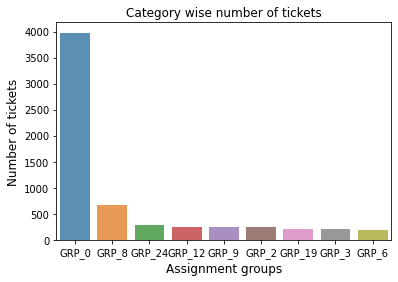

In [49]:
group_count = data_df['Assignment group'].value_counts()
sns.barplot(group_count.index[:9], group_count.values[:9], alpha=0.8)
plt.title('Category wise number of tickets')
plt.ylabel('Number of tickets', fontsize=12)
plt.xlabel('Assignment groups', fontsize=12)
plt.show()

46% of tickets are assigned to assignment group "GRP_0".

Check for caller wise count of tickets

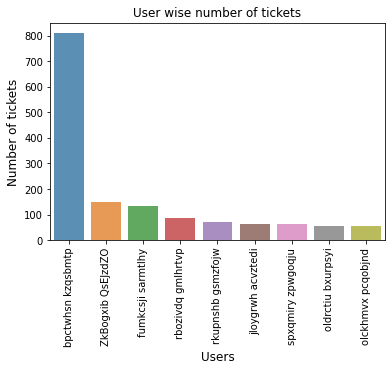

In [50]:
group_count = data_df['Caller'].value_counts()
sns.barplot(group_count.index[:9], group_count.values[:9], alpha=0.8)
plt.title('User wise number of tickets')
plt.ylabel('Number of tickets', fontsize=12)
plt.xlabel('Users', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The highest number of ticket created by a single user is 810 (approx 9% of all tickets).

Group 0 has a large number of tickets. Here is Group 0 analysis.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


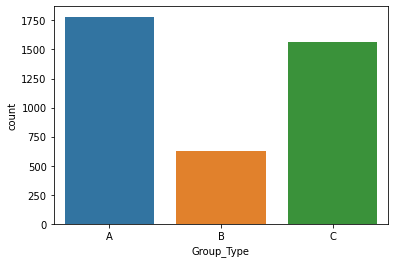

In [51]:
df2 = data_df[data_df['Assignment group']=='GRP_0']
pd.set_option("max_rows", None)
df2.dropna(axis=0,inplace=True)
df2.reset_index(drop=True,inplace=True)

group_type = []
for i in range (len(df2)):
    search_list1 = ['log', 'login', 'account', 'username','password', 'join','id','access','internet']
    search_list2 = ['software', 'server', 'vpn','microsoft','skype','gmail', 'outlook','email']
    if re.compile('|'.join(search_list1),re.IGNORECASE).search(df2['Short description'][i]):
        group_type.append('A')
    elif re.compile('|'.join(search_list2),re.IGNORECASE).search(df2['Short description'][i]):
        group_type.append('B')
    else :
        group_type.append('C')
        
df2['Group_Type'] = group_type

sns.countplot(df2['Group_Type'])

Find duplicates in data

In [52]:
data_df[data_df.duplicated()]

Short description  ... Assignment group
51                           call for ecwtrjnq jpecxuty  ...            GRP_0
229                          call for ecwtrjnq jpecxuty  ...            GRP_0
493                     ticket update on inplant_872730  ...            GRP_0
512                                    blank call //gso  ...            GRP_0
667   job bkbackup_tool_powder_prod_full failed in j...  ...            GRP_8
724                                          blank call  ...            GRP_0
1064  job Job_1967d failed in job_scheduler at: 10/1...  ...            GRP_8
1125                                        blank call   ...            GRP_0
1744                                        phone issue  ...            GRP_0
1851  reset passwords for fylrosuk kedgmiul using pa...  ...           GRP_17
1982                     call came and got disconnected  ...            GRP_0
2000  job Job_549 failed in job_scheduler at: 10/07/...  ...            GRP_8
2061                    blank call // loud noise // gso  ...            GRP_0
2141                                         blank call  ...            GRP_0
2533  reset passwords for qwsjptlo hnlasbed using pa...  ...           GRP_17
2554  reset passwords for bxeagsmt zrwdgsco using pa...  ...           GRP_17
2683                                     ticket update   ...            GRP_0
2714                         call for ecwtrjnq jpecxuty  ...            GRP_0
2720                                        german call  ...            GRP_0
2789                                         blank call  ...            GRP_0
2875                                         blank call  ...            GRP_0
2876                                         blank call  ...            GRP_0
3085                         call for ecwtrjnq jpecxuty  ...            GRP_0
3219                         call for ecwtrjnq jpecxuty  ...            GRP_0
3619                     call came and got disconnected  ...            GRP_0
3637                                        blank call   ...            GRP_0
3647      ç­”å¤: ç­”å¤: order products online problem  ...            GRP_0
3693  reset passwords for mvhcoqed konjdmwq using pa...  ...           GRP_17
3908  vpn not working- vpn.company.com  link is givi...  ...            GRP_0
4094  job Job_2883 failed in job_scheduler at: 09/18...  ...            GRP_8
4229  not able to access -inq industrial (-inq.indus...  ...            GRP_0
4273                                         blank call  ...            GRP_0
4303                         call for ecwtrjnq jpecxuty  ...            GRP_0
4361                               account locked in ad  ...            GRP_0
4495  job SID_37hoti failed in job_scheduler at: 09/...  ...            GRP_5
4530                                         blank call  ...            GRP_0
4550         call disconnected due to vpn disconnection  ...            GRP_0
4704  private address fields are enabled on employee...  ...           GRP_15
4881  install company barcode fÃ¼r ewew8323504 \vzqo...  ...           GRP_24
4984  reset passwords for cubdsrml znewqgop using pa...  ...           GRP_17
4991  reset passwords for davidthd robankm using pas...  ...           GRP_17
5212                                         blank call  ...            GRP_0
5226                                         blank call  ...            GRP_0
5317  reset passwords for bxeagsmt zrwdgsco using pa...  ...           GRP_17
5488  job SID_38hotf failed in job_scheduler at: 09/...  ...            GRP_8
5521                                   blank call //gso  ...            GRP_0
5708  reset passwords for bxeagsmt zrwdgsco using pa...  ...           GRP_17
5884  reset passwords for bxeagsmt zrwdgsco using pa...  ...           GRP_17
5928                    ticket update on inplant_855239  ...            GRP_0
5945                                   blank call //gso  ...            GRP_0
6058  reset passwords for bxeagsmt zrwdgsco using pa...  ...

In [53]:
data_df[data_df.duplicated()].count()

Short description    83
Description          83
Caller               83
Assignment group     83
dtype: int64

There are 84 duplicate tickets having all 4 columns same.

Word cloud on Description column

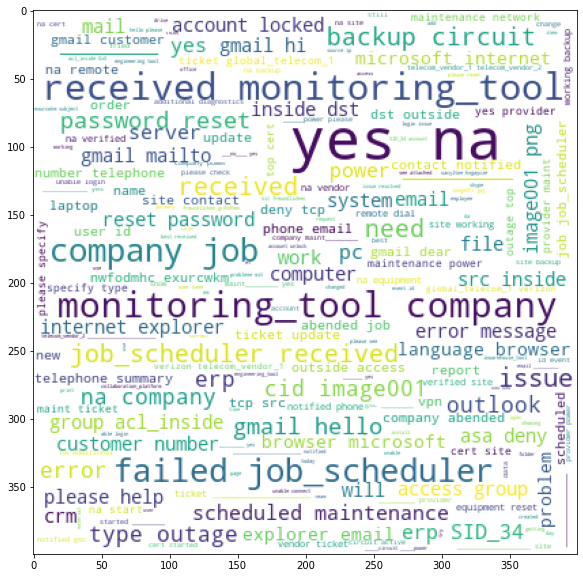

In [54]:
desc = " ".join(des for des in data_df.Description)

wc_desc = WordCloud(background_color='white', max_words=200, width=400, height=400,random_state=10).generate(desc)
plt.figure(figsize=(10,10))
plt.imshow(wc_desc)

Word cloud on Short description column

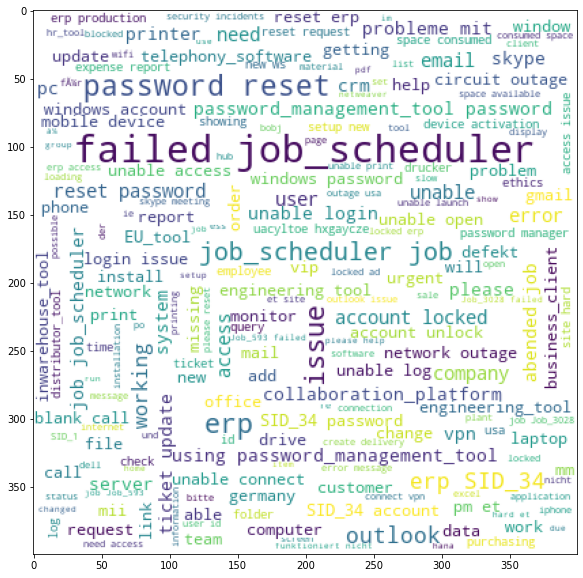

In [55]:
sh_desc = " ".join(sh_des for sh_des in data_df['Short description'])

wc_sh_desc = WordCloud(background_color='white', max_words=200, width=400, height=400,random_state=10).generate(sh_desc)
plt.figure(figsize=(10,10))
plt.imshow(wc_sh_desc)

Group wise word cloud

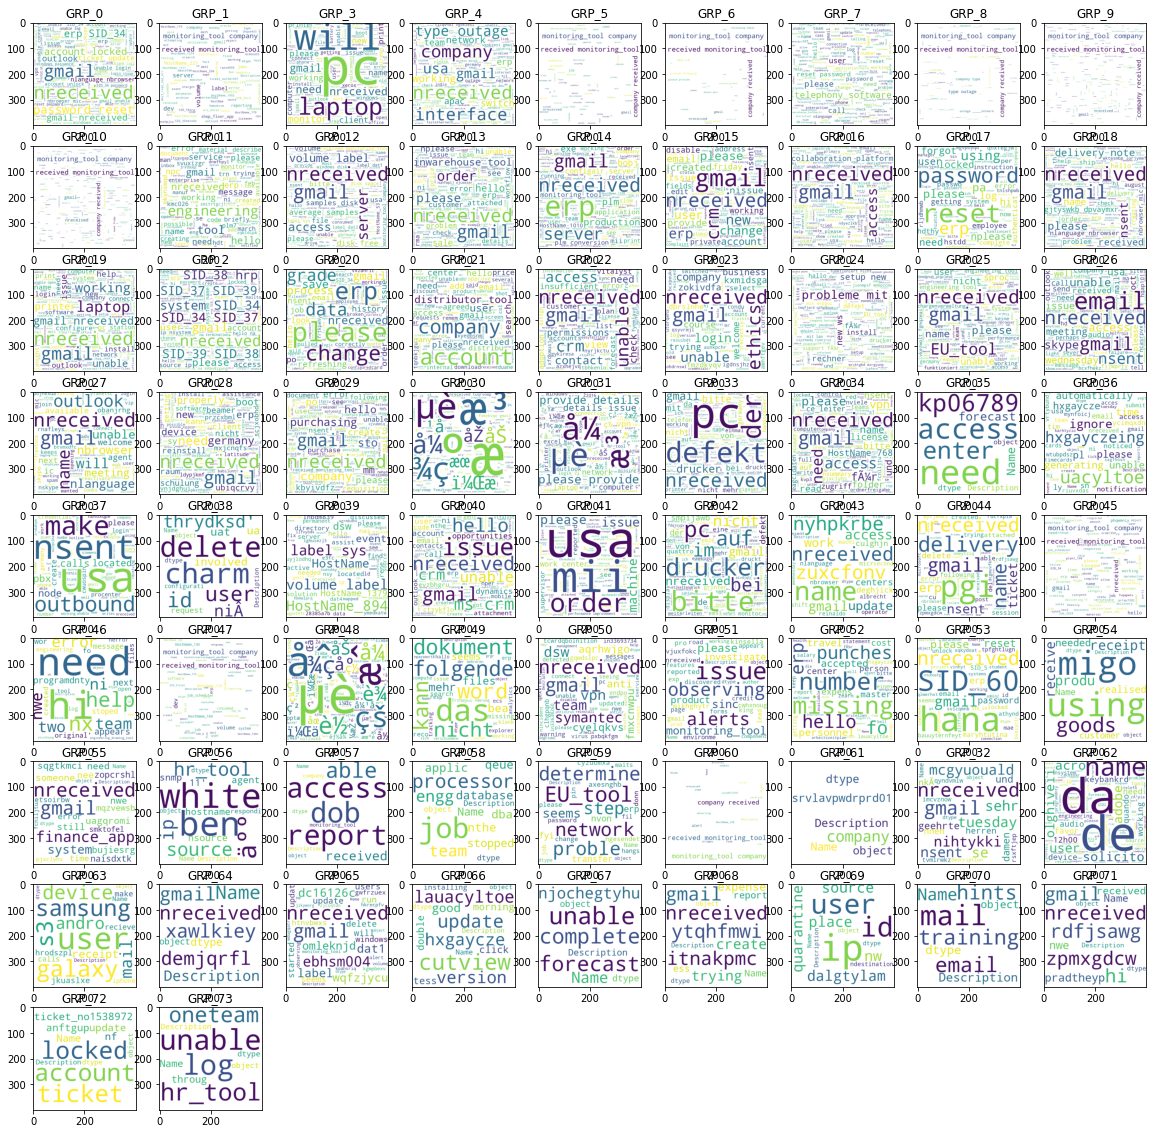

In [56]:
plt.figure(figsize=(20,20))

for index, i in enumerate(data_df['Assignment group'].unique()):
  s = str(i)
  i = str(data_df[data_df['Assignment group']==s].Description)
  i = WordCloud(background_color='white', max_words=200, width=400, height=400,random_state=10).generate(i)
  c = index+1
  plt.subplot(9,9,c)
  plt.imshow(i)
  plt.title(s)

**Data Preprocessing**

Remove duplicates

In [0]:
data_df.drop_duplicates(inplace=True)
data_df.reset_index(drop=True,inplace=True)

Remove "Reported by emailid" words 

In [0]:
#replacing email ids using caller column

import math
df1=[]
str1="";
validstring=1;
for i in data_df.index:
  validstring = 1;
  str1 = data_df.iloc[i].Description
  if str1 == '' or pd.isnull(str1):
      validstring=0;
  if validstring != 0:
    a = data_df.iloc[i].Caller.split()
    tp = a[0] + '.' + a[1] + '@gmail.com'
    if re.search( tp, data_df.iloc[i].Description ):
      str1 = data_df.iloc[i].Description.replace(tp,'')
      #print(i ," replaced")
  df1.append(str1)
tp = pd.DataFrame(df1,columns=["Description"])

In [0]:
#replacing 'received from:' string

df2=[]
validstring=1;
for i in tp.index:
  validstring=1;
  str1 = data_df.iloc[i].Description
  testString = 'received from:'
  if str1 == '' or pd.isnull(str1):
      validstring=0;
  if validstring != 0:
    if re.search( testString, tp.iloc[i].Description ):
      str1 = tp.iloc[i].Description.replace(testString,'')
      #print(i ," replaced")
  df2.append(str1)
tp2 = pd.DataFrame(df2,columns=["Description"])

In [0]:
#Remove all remaining email ids
for i in tp2.index:
  tp2.iloc[i].Description = tp2.iloc[i].Description.replace('\n', ' ').replace('\r', '')
  tp2.iloc[i].Description = re.sub(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)", '', tp2.iloc[i].Description)

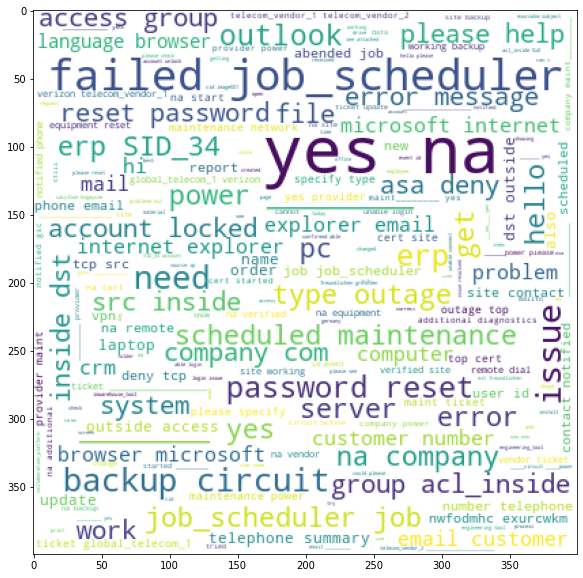

In [61]:
STOPWORDS = set(stopwords.words('english'))
esc2 = " ".join(des for des in tp2.Description)

wc_desc = WordCloud(background_color='white',stopwords=STOPWORDS, max_words=200, width=400, height=400,random_state=10).generate(esc2)
plt.figure(figsize=(10,10))
plt.imshow(wc_desc)

In [0]:
copy_df = data_df
copy_df["Description"] = df2
copy_df.head()
data_df = copy_df

In [63]:
data_df.head()

Short description  ... Assignment group
0                    login issue  ...            GRP_0
1                        outlook  ...            GRP_0
2             cant log in to vpn  ...            GRP_0
3  unable to access hr_tool page  ...            GRP_0
4                   skype error   ...            GRP_0

[5 rows x 4 columns]

Data normalization. Acronyms handling

In [0]:
contradictions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [65]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

The below method is used to clean the incoming text. The text is first converted to lower case,then contradictions are normalized and porter stemming is applied. After that the punctuations, special characters and stop words are removed.We also have some common stop words found within the dataset which we have removed as well.

In [0]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
def clean_text(text, remove_stopwords=True):
  STOPWORDS = set(stopwords.words('english'))
  porter = PorterStemmer()
  # Convert words to lower case
  text = text.lower()
  if True:
    text = text.split()
    if not text:
      return ' '
    new_text = []
    for word in text:
      if word in contradictions:
        new_text.append(porter.stem(contradictions[word]))
      elif word in string.punctuation:
        continue
      else:
        new_text.append(porter.stem(word))
      text = " ".join(new_text)
      text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
      text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
      text = text.replace('x', '')
      if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        newstop_words = ['yes','no','na','hello','hi','ticket','help','please','received','dear']
        text = [w for w in text if not w in newstop_words]
        text = " ".join(w for w in text if not w in stops)
  return text

In [0]:
data_df['Description'] = data_df['Description'].apply(clean_text)
data_df['Short description'] = data_df['Short description'].apply(clean_text)

In [68]:
data_df.isnull().any()

Short description    False
Description          False
Caller               False
Assignment group     False
dtype: bool

In [69]:
data_df.head()

Short description  ... Assignment group
0                 login issu  ...            GRP_0
1                    outlook  ...            GRP_0
2               cant log vpn  ...            GRP_0
3  unabl access hr_tool page  ...            GRP_0
4                skype error  ...            GRP_0

[5 rows x 4 columns]

Word cloud on description column after data clensing

In [0]:
STOPWORDS = set(stopwords.words('english'))

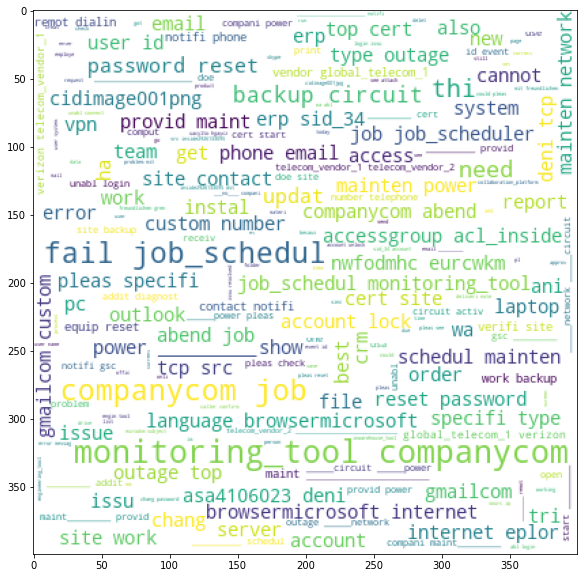

In [71]:
esc3 = " ".join(des for des in data_df.Description)

wc_desc = WordCloud(background_color='white',stopwords=STOPWORDS, max_words=200, width=400, height=400,random_state=10).generate(esc3)
plt.figure(figsize=(10,10))
plt.imshow(wc_desc)

Word cloud on Short description column after data clensing

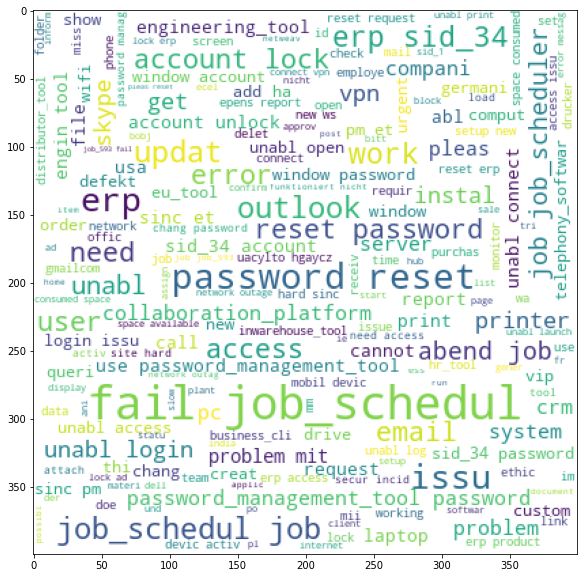

In [72]:
sh_desc2 = " ".join(sh_des for sh_des in data_df['Short description'])

wc_sh_desc = WordCloud(background_color='white',stopwords=STOPWORDS, max_words=200, width=400, height=400,random_state=10).generate(sh_desc2)
plt.figure(figsize=(10,10))
plt.imshow(wc_sh_desc)

Group wise word cloud

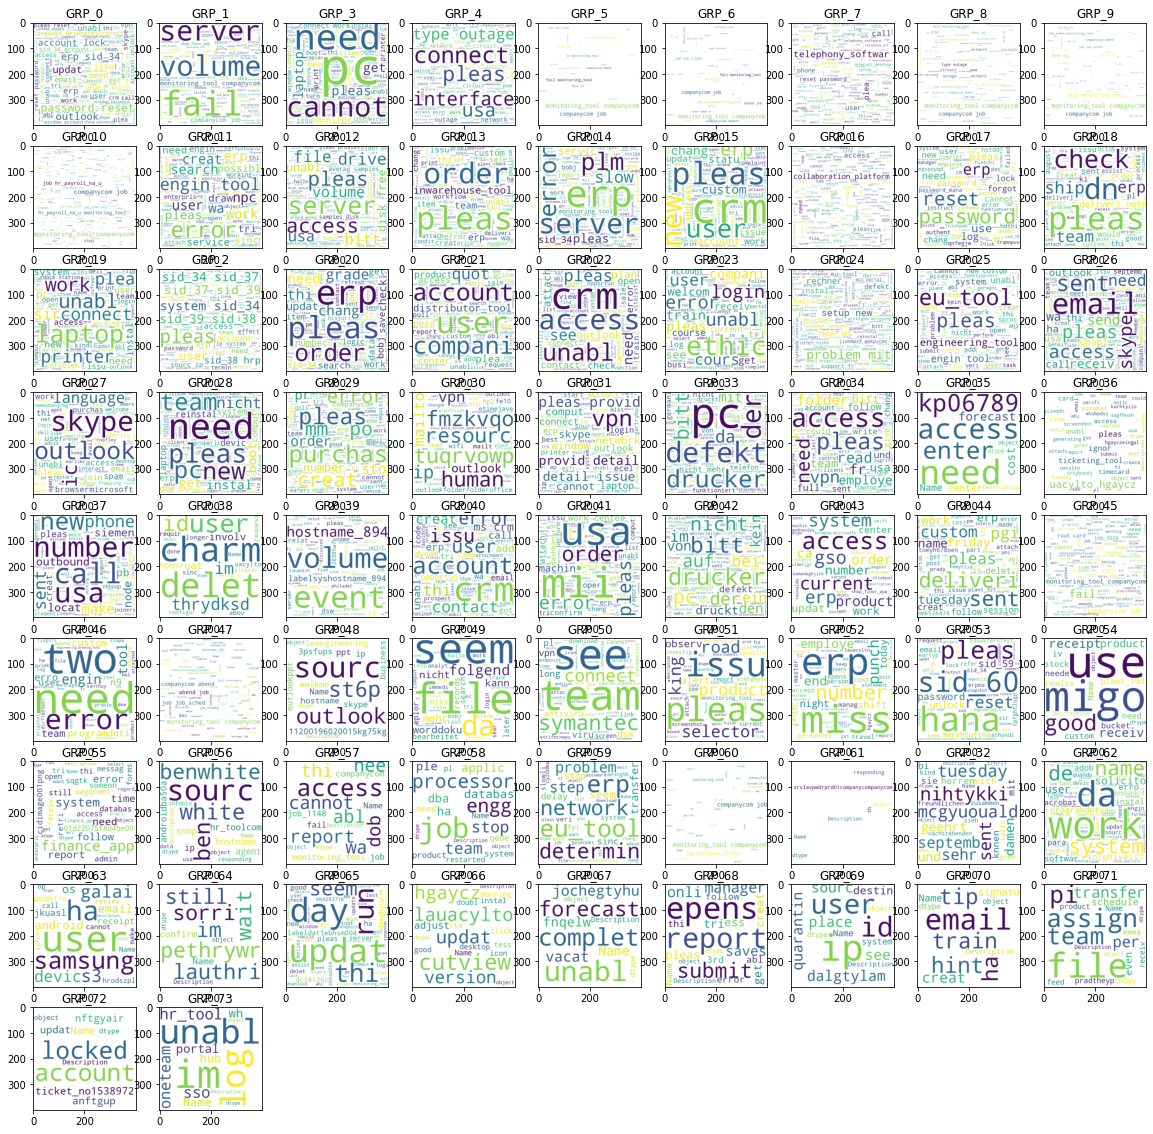

In [73]:
plt.figure(figsize=(20,20))

for index, i in enumerate(data_df['Assignment group'].unique()):
  s = str(i)
  i = str(data_df[data_df['Assignment group']==s].Description)
  i = WordCloud(background_color='white',stopwords=STOPWORDS, max_words=200, width=400, height=400,random_state=10).generate(i)
  c = index+1
  plt.subplot(9,9,c)
  plt.imshow(i)
  plt.title(s)

Dealing with Languages other than English

In [74]:
pip install fasttext

In [75]:
limodel = '/content/drive/My Drive/lid.176.ftz'
import fasttext
lid_model = fasttext.load_model(limodel) 
def predict_lang(model,texts): return model.predict(texts,k=1)
otherLanguagesDf = pd.DataFrame()

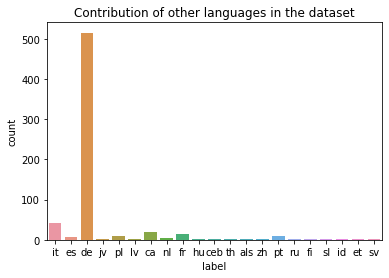

In [76]:
for index in data_df.index:
  prediction = predict_lang(lid_model,data_df.iloc[index]["Description"])
  label = prediction[0][0].split("__label__")[1]
  confidence = prediction[1][0]
  if label != "en" and confidence > 0.50:
    otherLanguagesDf = otherLanguagesDf.append({'index':index ,'label': label,"confidence": confidence, "text":data_df.iloc[index]["Description"]}, ignore_index=True)
plt.title("Contribution of other languages in the dataset")
sns.countplot(otherLanguagesDf['label'])

In [77]:
otherLanguagesDf['label'].value_counts()

de     515
it      42
ca      19
fr      14
pl      10
pt       9
es       6
nl       5
hu       3
ru       2
ceb      2
th       2
als      1
lv       1
fi       1
zh       1
sl       1
id       1
sv       1
et       1
jv       1
Name: label, dtype: int64

In [0]:
#Total other languages are 7% of whole dataset. We can remove these entries to make our dataset comprise only of English language tickets.
indexesToRemove = otherLanguagesDf["index"]

In [0]:
data_df = data_df.drop(indexesToRemove)

In [80]:
data_df.shape

(7779, 4)

**Model building**

Merge all columns into a single column

In [81]:
data_df['MergedColumn'] = data_df[data_df.columns[0:2]].apply(
    lambda x: ','.join(x.astype(str)),
    axis=1
)
data_df = data_df.drop(['Short description','Description','Caller'],axis=1)
data_df.head()

Assignment group                                       MergedColumn
0            GRP_0  login issu,verifi user details employee# manag...
1            GRP_0  outlook,team meetings skyp meet etc appear out...
2            GRP_0                   cant log vpn,cannot log vpn best
3            GRP_0  unabl access hr_tool page,unabl access hr_tool...
4            GRP_0                            skype error,skype error

Find the maximum length of the Merged column

In [82]:
max = 1
maxindex = 0;
lengthsdf = pd.DataFrame()
for ind in data_df.index:
  if len(data_df['MergedColumn'][ind]) > max:
    max = len(data_df['MergedColumn'][ind])
    maxindex = ind
print(max)

10685


Tokenize the Merged column

In [0]:
max_features = 1000
maxlen = 2500 
embedding_size = 200
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(data_df['MergedColumn'])

In [0]:
X = tokenizer.texts_to_sequences(data_df['MergedColumn'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data_df['Assignment group'])
y = pd.get_dummies(data_df['Assignment group']).values

Split data into train and test datasets

In [0]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Extract the GloVe embedding file

In [0]:
project_path = '/content/drive/My Drive/'
glove_file = project_path + "Copy_of_glove.6B.zip"
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

Embed each word

In [0]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

Find the num_words and create embedding matrix

In [88]:
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

Create model skeleton

In [89]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, weights = [embedding_matrix]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(74, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         4029400   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 200)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               120400    
_________________________________________________________________
dense (Dense)                (None, 74)                7474      
Total params: 4,157,274
Trainable params: 4,157,274
Non-trainable params: 0
_________________________________________________________________
None


Train the model

In [90]:
epochs = 15
batch_size = 64
 
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/15
88/88 [==============================] - 822s 9s/step - loss: 2.4341 - accuracy: 0.5180 - val_loss: 2.0782 - val_accuracy: 0.5474
Epoch 2/15
88/88 [==============================] - 818s 9s/step - loss: 1.9098 - accuracy: 0.5671 - val_loss: 1.9451 - val_accuracy: 0.5714
Epoch 3/15
88/88 [==============================] - 818s 9s/step - loss: 1.7354 - accuracy: 0.5886 - val_loss: 1.7840 - val_accuracy: 0.5827
Epoch 4/15
88/88 [==============================] - 820s 9s/step - loss: 1.5718 - accuracy: 0.6150 - val_loss: 1.6724 - val_accuracy: 0.5923
Epoch 5/15
88/88 [==============================] - 817s 9s/step - loss: 1.4360 - accuracy: 0.6350 - val_loss: 1.6043 - val_accuracy: 0.6116
Epoch 6/15
88/88 [==============================] - 817s 9s/step - loss: 1.3291 - accuracy: 0.6532 - val_loss: 1.5151 - val_accuracy: 0.6292
Epoch 7/15
88/88 [==============================] - 822s 9s/step - loss: 1.2297 - accuracy: 0.6721 - val_loss: 1.5183 - val_accuracy: 0.6164
Epoch 8/15
88

Test the model on test set

In [91]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 63.239074
